In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [12]:
np.random.seed(42)
n_samples = 1000

data = {
    'area_sqft': np.random.normal(800, 300, n_samples),
    'bedrooms': np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.1, 0.3, 0.4, 0.15, 0.05]),
    'bathrooms': np.random.choice([1, 2, 3, 4], n_samples, p=[0.2, 0.5, 0.25, 0.05]),
    'age_years': np.random.randint(0, 30, n_samples),
    'location_score': np.random.uniform(1, 10, n_samples),  # 1-10 scale
    'furnished': np.random.choice([0, 1], n_samples, p=[0.6, 0.4])  # 0=No, 1=Yes
}

In [14]:
base_rent = (
    data['area_sqft'] * 0.8 +
    data['bedrooms'] * 2000 +
    data['bathrooms'] * 1500 +
    (30 - data['age_years']) * 100 +
    data['location_score'] * 800 +
    data['furnished'] * 3000 +
    np.random.normal(0, 2000, n_samples)  # Add noise
)

In [16]:
data['rent_price'] = np.maximum(base_rent, 5000)  # Minimum rent of 5000

df = pd.DataFrame(data)
print(f"✅ Dataset created with {len(df)} samples")
print(f"📊 Dataset shape: {df.shape}")
df.head()

✅ Dataset created with 1000 samples
📊 Dataset shape: (1000, 7)


,area_sqft,bedrooms,bathrooms,age_years,location_score,furnished,rent_price
0,949.014246,2,2,24,1.293932,1,10927.826447
1,758.520710,2,1,16,5.280366,0,10391.502433
2,994.306561,3,1,12,4.669733,0,12079.784434
3,1256.908957,3,2,17,2.450969,0,15563.194525
4,729.753988,1,3,1,6.907686,0,13003.037109


# EDA

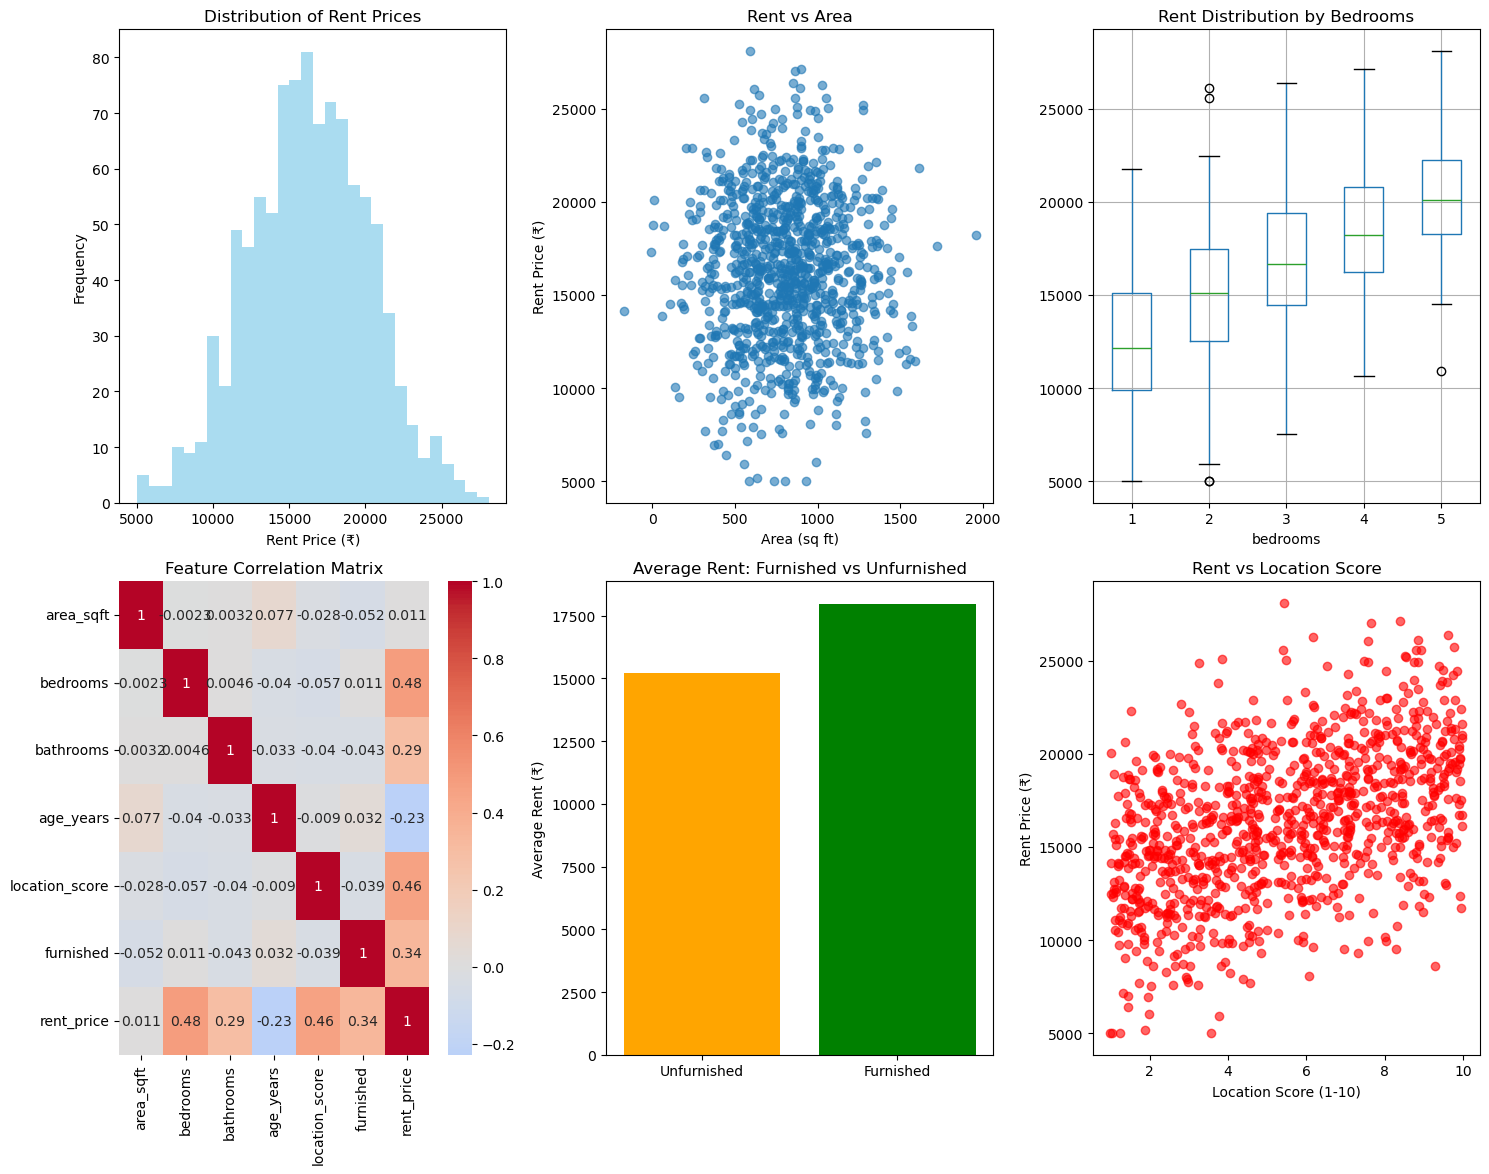

In [30]:
plt.figure(figsize=(15,12))

# Subplot 1: Rent distribution
plt.subplot(2, 3, 1)
plt.hist(df['rent_price'], bins=30, alpha=0.7, color='skyblue')
plt.title('Distribution of Rent Prices')
plt.xlabel('Rent Price (₹)')
plt.ylabel('Frequency')

# Subplot 2: Rent vs Area
plt.subplot(2, 3, 2)
plt.scatter(df['area_sqft'], df['rent_price'], alpha=0.6)
plt.title('Rent vs Area')
plt.xlabel('Area (sq ft)')
plt.ylabel('Rent Price (₹)')

# Subplot 3: Rent by Bedrooms
plt.subplot(2, 3, 3)
df.boxplot(column='rent_price', by='bedrooms', ax=plt.gca())
plt.title('Rent Distribution by Bedrooms')
plt.suptitle('')

# Subplot 4: Correlation Heatmap
plt.subplot(2, 3, 4)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

# Subplot 5: Furnished vs Unfurnished
plt.subplot(2, 3, 5)
furnished_rent = df.groupby('furnished')['rent_price'].mean()
plt.bar(['Unfurnished', 'Furnished'], furnished_rent, color=['orange', 'green'])
plt.title('Average Rent: Furnished vs Unfurnished')
plt.ylabel('Average Rent (₹)')

# Subplot 6: Location Score Impact
plt.subplot(2, 3, 6)
plt.scatter(df['location_score'], df['rent_price'], alpha=0.6, color='red')
plt.title('Rent vs Location Score')
plt.xlabel('Location Score (1-10)')
plt.ylabel('Rent Price (₹)')

plt.tight_layout()
plt.show()


In [32]:
# Display key statistics
print("📈 KEY INSIGHTS:")
print(f"• Average rent: ₹{df['rent_price'].mean():.0f}")
print(f"• Median rent: ₹{df['rent_price'].median():.0f}")
print(f"• Rent range: ₹{df['rent_price'].min():.0f} - ₹{df['rent_price'].max():.0f}")
print(f"• Strongest correlation with rent: {correlation_matrix['rent_price'].abs().sort_values(ascending=False).index[1]}")

📈 KEY INSIGHTS:
• Average rent: ₹16314
• Median rent: ₹16338
• Rent range: ₹5000 - ₹28094
• Strongest correlation with rent: bedrooms


In [35]:
X = df[['area_sqft', 'bedrooms', 'bathrooms', 'age_years', 'location_score', 'furnished']]
y = df['rent_price']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
models = {
    'Linear Regression' : LinearRegression(),
    'Randon Forest' : RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'R2': r2, 'model': model}
    
    print(f"📊 {name} Performance:")
    print(f"   Mean Absolute Error: ₹{mae:.0f}")
    print(f"   R² Score: {r2:.3f}")
    print()

📊 Linear Regression Performance:
   Mean Absolute Error: ₹1587
   R² Score: 0.771

📊 Randon Forest Performance:
   Mean Absolute Error: ₹1901
   R² Score: 0.676



In [43]:
# Select best model
best_model = max(results.keys(), key=lambda k: results[k]['R2'])
print(f"🏆 Best Model: {best_model} (R² = {results[best_model]['R2']:.3f})")

🏆 Best Model: Linear Regression (R² = 0.771)


In [45]:
# Use best model for detailed analysis
best_model_obj = results[best_model]['model']

In [47]:
# Feature importance (for Random Forest)
if best_model == 'Random Forest':
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model_obj.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.title('Feature Importance in Rent Prediction')
    plt.xticks(rotation=45)
    plt.ylabel('Importance')
    plt.show()

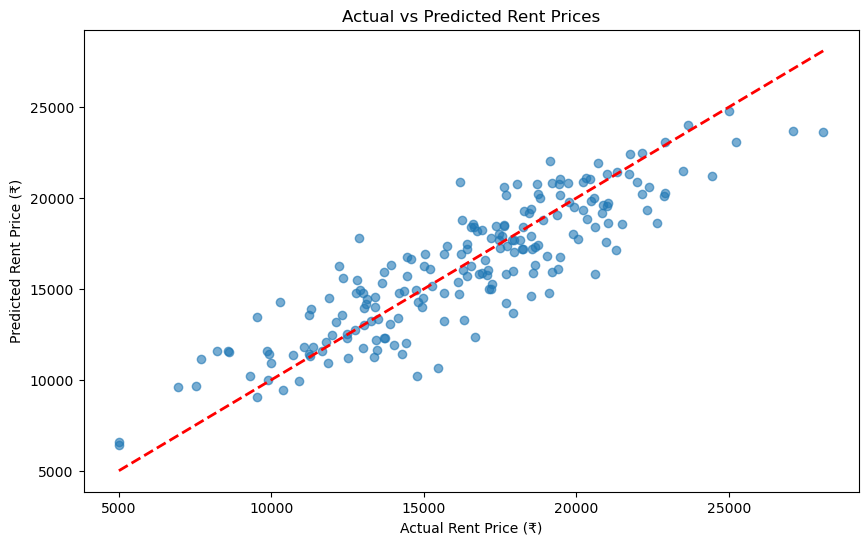

In [49]:
# Prediction vs Actual plot
y_pred_best = best_model_obj.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rent Price (₹)')
plt.ylabel('Predicted Rent Price (₹)')
plt.title('Actual vs Predicted Rent Prices')
plt.show()

In [51]:
# Sample predictions
print("🏠 SAMPLE PREDICTIONS:")
sample_houses = [
    [600, 2, 1, 5, 7.5, 1],   # Small furnished apartment
    [1200, 3, 2, 2, 8.0, 0],  # Medium unfurnished house
    [2000, 4, 3, 10, 6.0, 1]  # Large furnished house
]

for i, house in enumerate(sample_houses, 1):
    predicted_rent = best_model_obj.predict([house])[0]
    print(f"House {i}: ₹{predicted_rent:.0f}/month")
    print(f"  Features: {house[0]}sqft, {house[1]}BR, {house[2]}Bath, {house[3]}yrs old, Location:{house[4]}/10, Furnished:{bool(house[5])}")


🏠 SAMPLE PREDICTIONS:
House 1: ₹17282/month
  Features: 600sqft, 2BR, 1Bath, 5yrs old, Location:7.5/10, Furnished:True
House 2: ₹19024/month
  Features: 1200sqft, 3BR, 2Bath, 2yrs old, Location:8.0/10, Furnished:False
House 3: ₹23783/month
  Features: 2000sqft, 4BR, 3Bath, 10yrs old, Location:6.0/10, Furnished:True
